# 4. Analysis of Efficiency

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# All the transaction history predicted by classifier in 02_classifier.ipynb.
# Only contains r/GameSwap and r/GameSale. 500+ transactions in r/MushroomKingdom have been removed.
with open('./data/transaction_history_all.pkl', 'rb') as f:
    transaction_history_all = pickle.load(f)

In [3]:
# Get the original post using scraper.
%run get_original_post.py

original_post.pkl already exists
df_pre_2023-04-30_original.pkl already exists


In [4]:
# Confirmed transactions with original post date.
with open('./data/df_pre_2023-04-30_original.pkl', 'rb') as handle:
    data = pickle.load(handle)

data['confirmed_time'] = data['created_utc'] - data['created_utc_original']

In [5]:
# Check outliers.
data[data['confirmed_time'] <= pd.Timedelta(0)].head(2)

,user,index,author,body,created_utc,permalink,reply_author,reply_body,type,pred,subreddit,url,created_utc_original,confirmed_time
4165,frazzed,frazzed_5,NegativeGhostrider,Successful trade with /u/Frazzed \n\nTearaway ...,2014-07-07 20:10:42,/r/gameswap/comments/27atjl/successful_trade_t...,Frazzed,confirmed!,gameswap,NaN,gameswap,r/gameswap/comments/2a6wky,2014-07-08 23:40:05,-2 days +20:30:37
28217,negativeghostrider,negativeghostrider_0,NegativeGhostrider,Successful trade with /u/Frazzed \n\nTearaway ...,2014-07-07 20:10:42,/r/gameswap/comments/27atjl/successful_trade_t...,Frazzed,confirmed!,gameswap,NaN,gameswap,r/gameswap/comments/2a6wky,2014-07-08 23:40:05,-2 days +20:30:37


In [6]:
# Delete the rows with confirmed_time < 0. Outliers. 8 rows.
data = data[data['confirmed_time'] >= pd.Timedelta(0)]

In [7]:
# Check the rows without original post.
# Because in the confirmation post, the user doesn't specify the original post, so we can't get the original post.
transaction_history_all[~transaction_history_all.index.isin(data.index)]['body'].iloc[4]

'Completed trade with /u/mryelllow \n\nTraded Etrian Odyssey for Hyrule Warriors Legends. '

In [8]:
# Here, the user specified the original post so we can get the original post time.
transaction_history_all[transaction_history_all.index.isin(data.index)]['body'].iloc[0]

'Successful trade with u/rdmentalist. Gave Gears 3 and judg  for Assassins creed Unity. [Link](https://www.reddit.com/r/gameswap/comments/5906ut/usa_h_gears_123_judgement_codesxone_w_assassins/d94ro02/)'

## Total confirmations.

In [9]:
# Get the confirmed_time summary, grouping by type.
confirmed_time_summary = data.groupby('subreddit')['confirmed_time'].describe()
# export to latex table
# print(confirmed_time_summary.to_latex())
# round the time to days-hour format
confirmed_time_summary['mean'] = confirmed_time_summary['mean'].apply(lambda x: str(x.days) + ' days ' + str(x.seconds // 3600) + ' hours')
confirmed_time_summary['std'] = confirmed_time_summary['std'].apply(lambda x: str(x.days) + ' days ' + str(x.seconds // 3600) + ' hours')
confirmed_time_summary['min'] = confirmed_time_summary['min'].apply(lambda x: str(x.days) + ' days ' + str(x.seconds // 3600) + ' hours')
confirmed_time_summary['25%'] = confirmed_time_summary['25%'].apply(lambda x: str(x.days) + ' days ' + str(x.seconds // 3600) + ' hours')
confirmed_time_summary['50%'] = confirmed_time_summary['50%'].apply(lambda x: str(x.days) + ' days ' + str(x.seconds // 3600) + ' hours')
confirmed_time_summary['75%'] = confirmed_time_summary['75%'].apply(lambda x: str(x.days) + ' days ' + str(x.seconds // 3600) + ' hours')
confirmed_time_summary['max'] = confirmed_time_summary['max'].apply(lambda x: str(x.days) + ' days ' + str(x.seconds // 3600) + ' hours')
# Rename the columns
confirmed_time_summary = confirmed_time_summary.rename(columns={'mean': 'Mean', 'std': 'Std', 'min': 'Min', '25%': '25%', '50%': '50%', '75%': '75%', 'max': 'Max'})
confirmed_time_summary.index = ['GameSale', 'GameSwap']

confirmed_time_summary.unstack()


count  GameSale                 40218
       GameSwap                 12698
Mean   GameSale       14 days 6 hours
       GameSwap       23 days 1 hours
Std    GameSale       43 days 7 hours
       GameSwap       99 days 3 hours
Min    GameSale        0 days 0 hours
       GameSwap        0 days 0 hours
25%    GameSale        3 days 0 hours
       GameSwap        7 days 4 hours
50%    GameSale        6 days 5 hours
       GameSwap       11 days 1 hours
75%    GameSale       11 days 1 hours
       GameSwap       17 days 5 hours
Max    GameSale     1524 days 3 hours
       GameSwap    3089 days 13 hours
dtype: object

## Confirmed in one week.

In [10]:
confirmed_one_data = data.loc[data['confirmed_time']<=pd.Timedelta(1, unit='w')]
confirmed_one_data.groupby('subreddit')['confirmed_time'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
gamesale,22252,3 days 04:20:17.752426748,2 days 08:03:15.511364984,0 days 00:04:35,0 days 17:10:25,3 days 10:43:25,5 days 05:23:54.250000,6 days 23:59:44
gameswap,2973,4 days 05:59:22.215607130,2 days 04:46:35.511006842,0 days 00:03:55,2 days 19:19:08,4 days 21:23:05,6 days 00:50:19,6 days 23:58:26


## Confirmance time in each year.

In [11]:
data['year'] = data['created_utc_original'].dt.year
data['month'] = data['created_utc_original'].dt.month

In [12]:
confirmation_time_by_year = data.loc[(data['year']>=2013)&(data['year']<=2021)].groupby(['subreddit', 'year'])['confirmed_time'].describe().pivot_table(index='year', columns='subreddit', values='mean')
confirmation_time_by_month = data.loc[(data['created_utc_original']>='2013-10-1')&(data['created_utc_original']<='2021-12-31')].groupby(['subreddit', 'year','month'])['confirmed_time'].describe().pivot_table(index=['year','month'], columns='subreddit', values='mean')

In [13]:
confirmation_time_by_month = confirmation_time_by_month.fillna(pd.Timedelta(0))
confirmation_time_by_month['gamesale'] = confirmation_time_by_month['gamesale'].apply(lambda x: x.days * 24 + x.seconds // 3600)
confirmation_time_by_month['gameswap'] = confirmation_time_by_month['gameswap'].apply(lambda x: x.days * 24 + x.seconds // 3600)
confirmation_time_by_month = confirmation_time_by_month.reset_index()
confirmation_time_by_month['date'] = confirmation_time_by_month['year'].astype(str) + '-' + confirmation_time_by_month['month'].astype(str)
confirmation_time_by_month = confirmation_time_by_month.set_index('date')

In [14]:
confirmation_time_by_month.index = pd.to_datetime(confirmation_time_by_month.index)

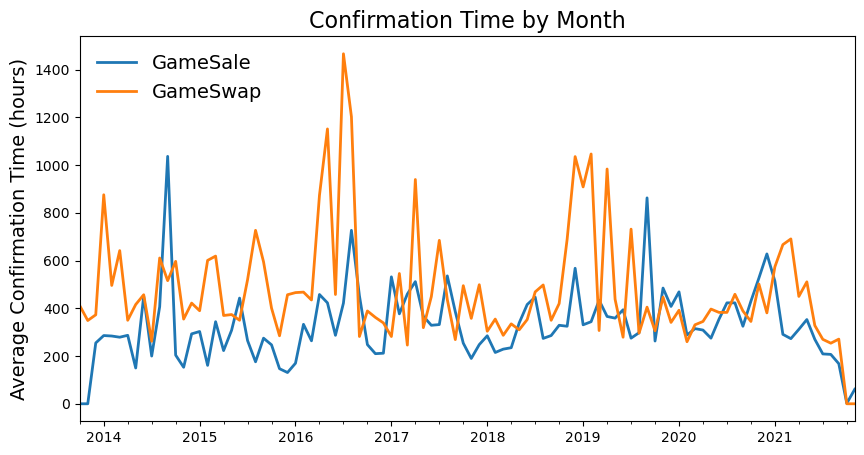

In [23]:
confirmation_time_by_month.plot(figsize=(10, 5),y=['gamesale','gameswap'],linewidth=2)
plt.legend(['GameSale', 'GameSwap'],loc='upper left',frameon=False,fontsize=14)
plt.xlabel('')
plt.ylabel('Average Confirmation Time (hours)',fontsize=14)
plt.title('Confirmation Time by Month',fontsize=16)
plt.savefig('./plot/confirmation_time_by_month.png', dpi=300, bbox_inches='tight',transparent=True)

In [24]:
confirmation_time_by_year['gamesale'] = confirmation_time_by_year['gamesale'].apply(lambda x: x.days * 24 + x.seconds // 3600)

In [25]:
confirmation_time_by_year['gameswap'] = confirmation_time_by_year['gameswap'].apply(lambda x: x.days * 24 + x.seconds // 3600)

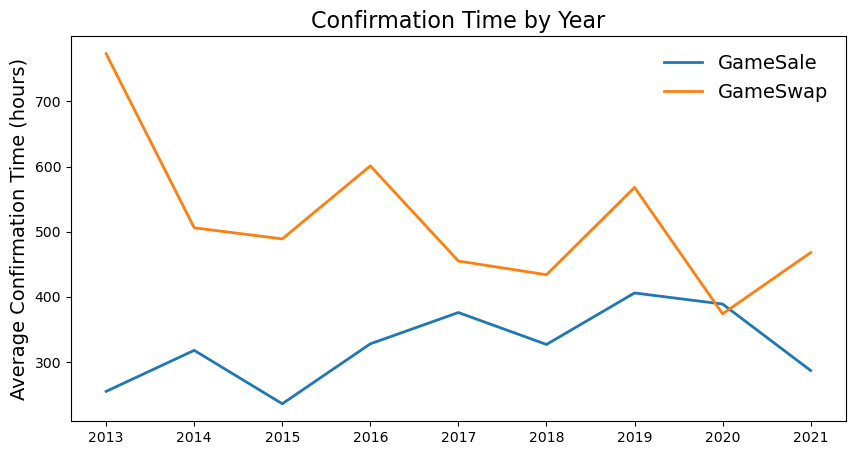

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(confirmation_time_by_year['gamesale'], label='GameSale',linewidth=2)
ax.plot(confirmation_time_by_year['gameswap'], label='GameSwap',linewidth=2)
ax.set_ylabel('Average Confirmation Time (hours)', fontsize=14)
ax.set_xlabel('')
ax.legend(frameon=False,fontsize=14)
ax.set_title('Confirmation Time by Year',fontsize=16)
fig.savefig('./plot/confirmation_time_by_year.png', dpi=300, bbox_inches='tight',transparent=True)
plt.show()